# Implementing generalized measurements with mid-circuit measurements

**Contributors:** Alireza Seif, Derek Wang, Gideon Uchehara, Peter Ivashkov

## Introduction <a id='intro'></a>

Implementing generalized measurements in the form of positive operator valued measurements (POVM) is non-trivial, and to this end, several methods have been proposed. To compare contrasting approaches, we focus on two methods: Naimark's extension and the binary tree search methods, which significantly differ in terms of their scaling with the size of the POVM set and the hardware resources necessary to implement them.

In this tutorial, we first introduce the theory behind generalized measurements and show how they can be implemented in Qiskit using Naimark's extension. After that, we demonstrate the implementation of the binary search tree approach using the protocol described by [Andersson and Oi](https://arxiv.org/abs/0712.2665) for a tetrad POVM using a single auxiliary qubit, thus demonstrating a promising application of mid-circuit measurements and feed-forward capabilities of near-term quantum devices.

## Defining classes and functions <a id='beginning'></a>

To be able to follow this notebook, please first go to the [implementation section](#implementation) and execute two cells containing Python implementations of binary search and Naimark's algorithms. These sections define necessary classes and functions that will be used later in the notebook. After that, you can return to this section and continue with the notebook.

## Understanding generalized measurements <a id='povm'></a>

Generalized measurement or [POVM](https://en.wikipedia.org/wiki/POVM) is the most general kind of measurement in quantum mechanics. Formally, POVM is a set of measurement operators $\{ M_a\}$ which are Hermitian ($M_a^\dagger = M_a$), positive ($\bra{\psi} M_a \ket{\psi} \ge 0$), and complete ($\sum_a M_a = I$). However, notice that POVM operators are, in general, not orthogonal projectors, i.e., $M_i M_j \neq \delta_{ij} M_i$,  in contrast to standard projective measurements. The probability of measuring outcome $a$ of the POVM is given by Born's rule as $p(a) = Tr(\rho M_a)$. Finally, the post-measurement state upon getting an outcome $M_a$ is $\rho_{post} = \frac{m_a \rho m_a^\dagger}{Tr(\rho M_a)}$, where $m_a$ are the coresponding Kraus operators, i.e., $m_a^\dagger m_a = M_a$.

POVMs are, in fact, a generalization of projective measurements. They can be implemented by performing a projective measurement on the joint state of the system of interest coupled to an auxiliary system by a suitable unitary operation. POVMs are extensively used in quantum information processing. For instance, with POVMs, one can perform unambiguous state discrimination. The focus of this tutorial is the efficient implementation of POVMs.

## Tetrad POVM: proof of concept <a id='tetrad-povm'></a>
First, let's examine our POVM of interest - the tetrad POVM. This POVM is a symmetric informationally complete POVM (SIC-POVM) on a single qubit. Tetrad POVM has four elements $\{ M_i = \ket{\psi_i}\bra{\psi_i} \}_{i=0}^3$, where $\ket{\psi_i}$ are given as follows:

$$\ket{\psi_0} = \frac{1}{\sqrt{2}}\ket{0}$$

$$\ket{\psi_1} = \frac{1}{\sqrt{6}}(\ket{0} + \sqrt{2}e^{2\pi i/3}\ket{1})$$

$$\ket{\psi_2} = \frac{1}{\sqrt{6}}\ket{0} + \sqrt{2}e^{4\pi i/3}\ket{1})$$

$$\ket{\psi_3} = \frac{1}{\sqrt{6}}(\ket{0} + \sqrt{2}\ket{1})$$

One can implement this POVM using Neumark's extension with a single auxiliary qubit and one projective measurement. Therefore, we wouldn't expect the binary tree approach to provide any improvement in terms of required ancilla qubits. We will nevertheless use this simple case POVM to demonstrate both algorithms.

One can easily verify that this POVM satisfies the requirements for a [SIC-POVM](https://en.wikipedia.org/wiki/SIC-POVM). The state vectors can be represented on the Bloch sphere:

![tetrad_povm](https://raw.githubusercontent.com/petr-ivashkov/qamp-generalized-measurements-img/master/Images/tetrad_povm.png)

Let's define our POVM and the initial state of the system. Note that in our case, we have chosen the initial state to be $\ket{0}$ for simplicity. The implementation, however, works for any other initial state. We refer to POVM as a list of its measurement operators.

In [6]:
import numpy as np
from cmath import pi, sqrt, exp

# Define the set of vectors on the Bloch sphere
psi_0 = np.array([[1/sqrt(2)],[0]])
psi_1 = np.array([[1],[sqrt(2)*exp(2j*pi/3)]])/sqrt(6)
psi_2 = np.array([[1],[sqrt(2)*exp(4j*pi/3)]])/sqrt(6)
psi_3 = np.array([[1],[sqrt(2)]])/sqrt(6)

# POVM elements are given as M_i = |psi_i><psi_i|
M0 = psi_0@psi_0.conj().T
M1 = psi_1@psi_1.conj().T
M2 = psi_2@psi_2.conj().T
M3 = psi_3@psi_3.conj().T

# POVM is a list of its elements
povm = [M0, M1, M2, M3]

# Initial (pure) state of the system is |0>
state = np.array([[1, 0]])
state = state/np.linalg.norm(state)

## Naimark's extension <a id='naimark'></a>

Naimark's extension theory provides the path to implement  generalized POVM measurement using projective von Neumann measurements by enlarging the Hilbert space of the measured system with an auxiliary quantum system, as shown in the figure below: 

![naimark_extension](https://raw.githubusercontent.com/petr-ivashkov/qamp-generalized-measurements-img/master/Images/naimarks_povm.PNG)

In the above figure, an auxiliary system $\ket{0}_B$ (also known as ancilla) is introduced to the system of interest $\rho_A$. This is similar to bringing Bob to help Allice in measuring the POVM elements.

More formally, for every POVM $\{M_a\}_{a \in \mathcal{A}}$, there exists an isometry U such that 

$$
\begin{split}
    M_a &= U^\dagger \left( \mathcal{I} \otimes \ket{a}\bra{a} \right) U \; \forall \; a \in \mathcal{A}.
    %\label{eq1}
\end{split}
$$

By implication, the isometry, $U$ can be defined as

$$U = \sum_{a \in \mathcal{A}} M_a \otimes \ket{a}$$

The following section will show how to construct Naimark's extension circuit and measure the tetrad POVM using a single auxiliary qubit and one projective measurement.

### Constructing Naimark's extension circuit

Given the POVM and the initial state of the system of interest, we can construct the circuit for Naimark's extension using the function `construct_quantum_circuit()`. Considering that the isometry (unitary), $U$ is at the heart of Naimark's extension implementation, we created two functions, `compute_rank_one_unitary()` and `compute_full_rank_unitary()`, to construct the unitary for a rank-1 and non-rank-1 POVMs respectively. The function, `construct_quantum_circuit()` checks for the rank of the given POVM and creates the Naimark's extension circuit using the functions `rank_one_circuit()` and `full_rank_circuit()` for rank-1 and non-rank-1 POVMs respectively. 

To implement this in Qiskit, let's import the relevant libraries.

In [7]:
# Naimark's quantum circuit for the tetrad POVM and state |0>
qc = construct_quantum_circuit(povm, state)

Let's visualize this circuit:

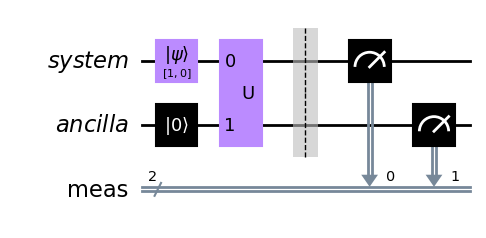

In [8]:
qc.draw("mpl")

Our next step would be to run the Naimark's circuit. We will defer the theoretical and simulated results for this circuit to when we have obtained the hardware result.

Let's get the backends assoicated with our account

In [9]:
from qiskit import IBMQ

# Load account and get backends
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

### Selecting an optimal layout using mapomatic

Since we have access to multiple quantum backends, we want to select an optimal backend and an optimal layout to execute our transpiled circuit. In the following, we will use `mapomatic`, which will be discussed in more detail in the [appendix](#appendix). 

In [10]:
import mapomatic as mm
from qiskit import transpile

backend = provider.get_backend('ibmq_lima')
transpiled_qc = transpile(qc, backend=backend, optimization_level=3)
small_qc = mm.deflate_circuit(transpiled_qc)

# Note: evaluating all available backends might block your environment for a long period
backends = [provider.get_backend('ibmq_lima'), provider.get_backend('ibm_nairobi'), provider.get_backend('ibm_oslo')]

scores = mm.best_overall_layout(small_qc, backends, successors=True)
print("Backends with the corresponding optimal layouts in ascending order. First backend is optimal.")
for score in scores: print(score)

initial_layout = scores[0][0]

Backends with the corresponding optimal layouts in ascending order. First backend is optimal.
([1, 2], 'ibm_oslo', 0.048246822245851195)
([1, 0], 'ibmq_lima', 0.06473001465010009)
([4, 5], 'ibm_nairobi', 0.0734194177317139)


In [11]:
from qiskit import transpile
trans_qc = transpile(qc, backend=backend, initial_layout=initial_layout, optimization_level=3)

Let's visualize our Naimark's circuit transpiled for the best backend and initial layout found with `mapomatic`.

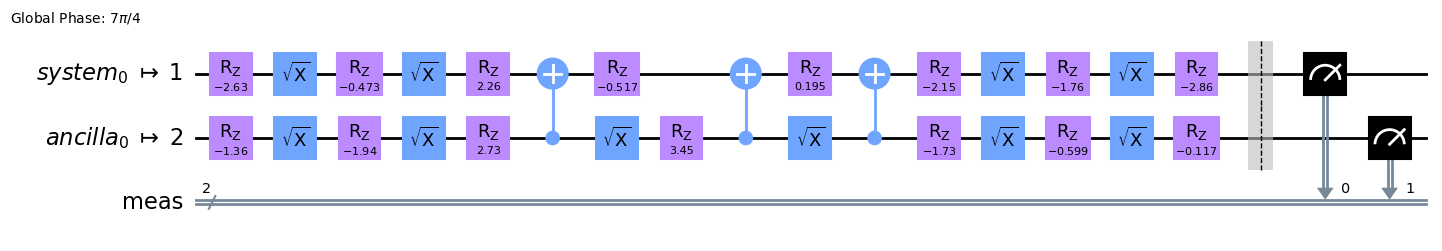

In [12]:
trans_qc.draw('mpl',idle_wires=False)

### Simulating Naimark's circuit with the noise model of real backend

Before running the Naimark's circuit on actual quantum hardware, we simulated it using the noise model of the best backend as follows:

In [13]:
from qiskit_aer.noise import NoiseModel
noise_model = NoiseModel.from_backend(backend)

For this simulation, we will use the `ibmq_qasm_simulator` and feed it with the noise model for our best backend.

In [14]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel='ibm_quantum')
# Simulator backend
simulator = service.backends(simulator=True)[0]
print(simulator)

<IBMBackend('ibmq_qasm_simulator')>


To account for error mitigation, we will use the Qiskit runtime, `Sampler`. For details on this, please see the <a class="reference external" href="https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.Sampler.html">Sampler documentation</a>.

In [15]:
from qiskit_ibm_runtime import Sampler, Estimator, Session, Options

# Set options to include noise_model only (noisy simulation)
options = Options(simulator={
    "noise_model": noise_model,
    "seed_simulator": 42,
}, resilience_level=0)

# Set options to include noise_model and resilience_level (for error mitigation)
options_with_em = Options(
    simulator={
        "noise_model": noise_model,
        "seed_simulator": 42,
    },  
    resilience_level=1
)

with Session(service=service, backend=simulator):
    sampler = Sampler(options=options)
    noisy_job = sampler.run(circuits=[trans_qc])
    print(f"Noisy Job ID: {noisy_job.job_id()}")
    noisy_results = noisy_job.result()
    
    sampler = Sampler(options=options_with_em)
    em_job = sampler.run(circuits=[trans_qc])
    em_job = sampler.run(circuits=[trans_qc])
    print(f"Error mitigated Job ID: {em_job.job_id()}")
    em_results = em_job.result()

Noisy Job ID: cev9hvkdo0fpfg2jpe20
Error mitigated Job ID: cev9i1p3v4f6ud9rn2ug


Now that we have our results, let's visualize them.

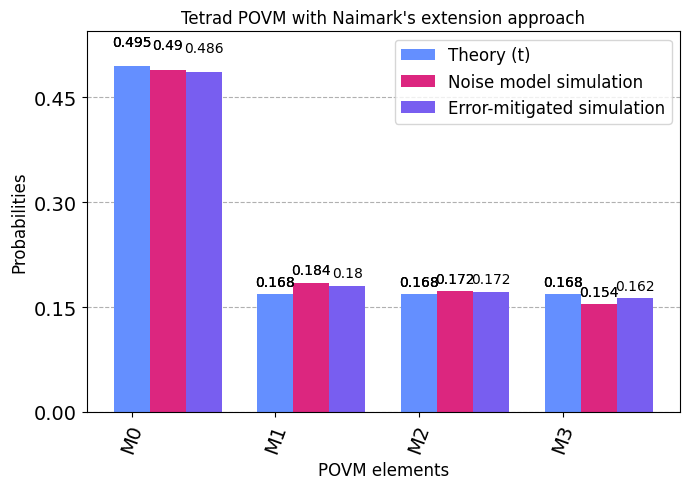

In [16]:
noisy_prob = noisy_results.quasi_dists[0]
l = len(noisy_prob)
n = int(np.ceil(np.log2(l)))

noisy_prob = {np.binary_repr(key, n): value for key, value in noisy_prob.items()}

em_prob = em_results.quasi_dists[0]
em_prob = {np.binary_repr(key, n): value for key, value in em_prob.items()}

names = ["Noise model simulation", "Error-mitigated simulation"]
counts = [noisy_prob, em_prob]
naimark_plot(povm, state, counts, names, save=False)

The above plot shows that the noise model and error mitigated simulations are close to the theoretical values.

### Running transpiled circuit on the real backend

We are basically going to repeat the same thing we did for the simulations above, except that, in this case, we will replace the backends with the actual quantum hardware.

In [17]:
# Define the best backend to use
backend = service.get_backend(scores[0][1])
print(backend)

<IBMBackend('ibm_oslo')>


Uncomment the following lines of code to run this on real quantum hardware -- the best hardware we determined using `mapomatic`. In our case, we have decided to use the result obtained from our previous run. Note that this was done using `shots=1024`. Using the default number of shots may give a better result.

In [18]:
  
"""
# Set options for noisy hardware run (without resilience to noise)
options = Options(resilience_level=0)

# Set options to include noisy hardware and resilience_level for noise mitigation
options_with_em = Options(resilience_level=1)


with Session(service=service, backend=backend):
    sampler = Sampler(options=options)
    noisy_hardware_job = sampler.run(circuits=[best_trans_qc], shots=1024)
    print(f"Noisy Job ID: {noisy_hardware_job.job_id()}")
    noisy_hardware_results = noisy_hardware_job.result()
    
    sampler = Sampler(options=options_with_em)
    em_hardware_job = sampler.run(circuits=[best_trans_qc], shots=1024)
    print(f"Error mitigated Job ID: {em_hardware_job.job_id()}")
    em_hardware_results = em_hardware_job.result()

"""

'\n# Set options for noisy hardware run (without resilience to noise)\noptions = Options(resilience_level=0)\n\n# Set options to include noisy hardware and resilience_level for noise mitigation\noptions_with_em = Options(resilience_level=1)\n\n\nwith Session(service=service, backend=backend):\n    sampler = Sampler(options=options)\n    noisy_hardware_job = sampler.run(circuits=[best_trans_qc], shots=1024)\n    print(f"Noisy Job ID: {noisy_hardware_job.job_id()}")\n    noisy_hardware_results = noisy_hardware_job.result()\n    \n    sampler = Sampler(options=options_with_em)\n    em_hardware_job = sampler.run(circuits=[best_trans_qc], shots=1024)\n    print(f"Error mitigated Job ID: {em_hardware_job.job_id()}")\n    em_hardware_results = em_hardware_job.result()\n\n'

You can visualize the result after the job has completed by uncommenting and running the code below

In [19]:
"""
noisy_hardware_prob = noisy_hardware_results.quasi_dists[0]
l = len(noisy_hardware_prob)
n = int(np.ceil(np.log2(l)))

noisy_hardware_prob = {np.binary_repr(key, n): value for key, value in noisy_hardware_prob.items()}

em_hardware_prob = em_hardware_results.quasi_dists[0]
em_hardware_prob = {np.binary_repr(key, n): value for key, value in em_hardware_prob.items()}

names = ["Hardware", "Error-mitigated"]
counts = [noisy_hardware_prob, em_hardware_prob]
naimark_plot(povm, state, counts, names, save=True, file_name="hardware_output.pdf")
"""

'\nnoisy_hardware_prob = noisy_hardware_results.quasi_dists[0]\nl = len(noisy_hardware_prob)\nn = int(np.ceil(np.log2(l)))\n\nnoisy_hardware_prob = {np.binary_repr(key, n): value for key, value in noisy_hardware_prob.items()}\n\nem_hardware_prob = em_hardware_results.quasi_dists[0]\nem_hardware_prob = {np.binary_repr(key, n): value for key, value in em_hardware_prob.items()}\n\nnames = ["Hardware", "Error-mitigated"]\ncounts = [noisy_hardware_prob, em_hardware_prob]\nnaimark_plot(povm, state, counts, names, save=True, file_name="hardware_output.pdf")\n'

You can obtain hardware results for Naimark's approach by following the steps above. The figure below shows one of the previous hardware experiments for Naimark's extension circuit.

![naimark_hw_results](https://raw.githubusercontent.com/petr-ivashkov/qamp-generalized-measurements-img/master/Images/naimark_hw_results.png)

The above plot compares the hardware result with the theoretical and error-mitigated results. Although there are some deviations from the theoretical values, the difference is not so much. 

`Hellinger()` stands for the [Hellinger fidelity](https://en.wikipedia.org/wiki/Hellinger_distance) between different results.

In the next section we demonstrate the implementation of the tetrad POVM using the binary tree approach.

## Binary tree approach <a id='binary-tree'></a>

### Constructing binary tree circuit

POVMs can be implemented through a binary search approach with a depth logarithmic in the number of possible outcomes. The algorithm was introduced and formalized by [Andersson and Oi](https://arxiv.org/abs/0712.2665). The following explains and illustrates a Python implementation of the binary tree approach to measure the tetrad POVM.

The approach performs a binary search by iteratively applying coupling unitaries conditioned on the results of mid-circuit measurements and measuring the ancilla in the computational basis. At each node, the number of possible outcomes is halved. The fine-grain level of the binary tree corresponds to the final POVM outcomes. The procedure for constructing suitable coupling unitaries is briefly explained in the [appendix](#appendix), while the exact algorithm is outlined in the [original paper](https://arxiv.org/abs/0712.2665).

![sequential_povm](https://raw.githubusercontent.com/petr-ivashkov/qamp-generalized-measurements-img/master/Images/sequential_povm.png)

The implementation in the form of a Python module consists of the central class `BinaryTreePOVM` and several helper functions. It creates a simple way to construct a measurement circuit for an arbitrary POVM. We will use it to build the corresponding measurement circuit for the tetrad POVM on a single qubit system.

We initialize a `BinaryTreePOVM` object **btp**, which holds information about the POVM, the coupling unitaries, and the `QuantumCircuit` itself.

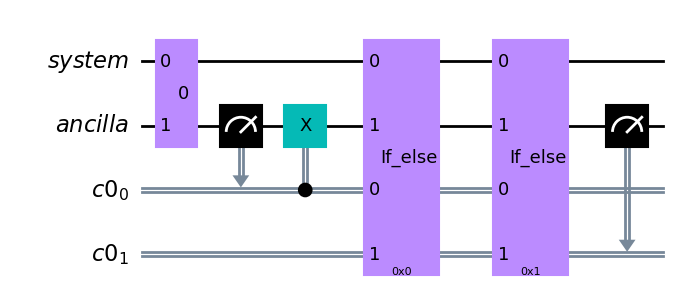

In [20]:
btp = BinaryTreePOVM(povm)

btp.qc.draw('mpl')

Note how a conditional X gate is applied instead of a reset after the mid-circuit readout. This trick reduces the error rate because the reset operation is significantly longer and noisier than an X gate. This idea was described and implemented in [Marz](https://github.com/Qiskit-Partners/marz).

### Simulating binary tree circuit with readout errors

Instead of running the circuit on a backend noise model, we create a custom noise model with only readout errors by applying a `pauli_error` *X*  on `measure` instructions. This way, one can assess the effect of readout errors in our dynamic circuit. In contrast to the standard readout at the end of the circuit, errors from mid-circuit measurements propagate through the circuit if subsequent gates are conditioned on preceding classical measurement outcomes. In other words, an incorrectly measured bit will trigger the wrong conditional unitary. In this case, the evolution of the quantum state is affected by imperfect mid-circuit measurements.

In [21]:
from qiskit_ibm_provider import IBMProvider

provider = IBMProvider()
backend = provider.get_backend('ibm_nairobi', instance='ibm-q/open/main')

Let's create a noise model where an *X* error occurs with probability `e = 0.03` during the measurement. The chosen value for `e` is close to real hardware readout errors.

In [22]:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error
e = 0.03
noise_model_classical = NoiseModel()
error_meas = pauli_error([('X',e), ('I', 1-e)])

noise_model_classical.add_quantum_error(error_meas, "measure", [1])

simulator_noisy = AerSimulator(noise_model=noise_model_classical)

Let's transpile and visualize our binary tree circuit.

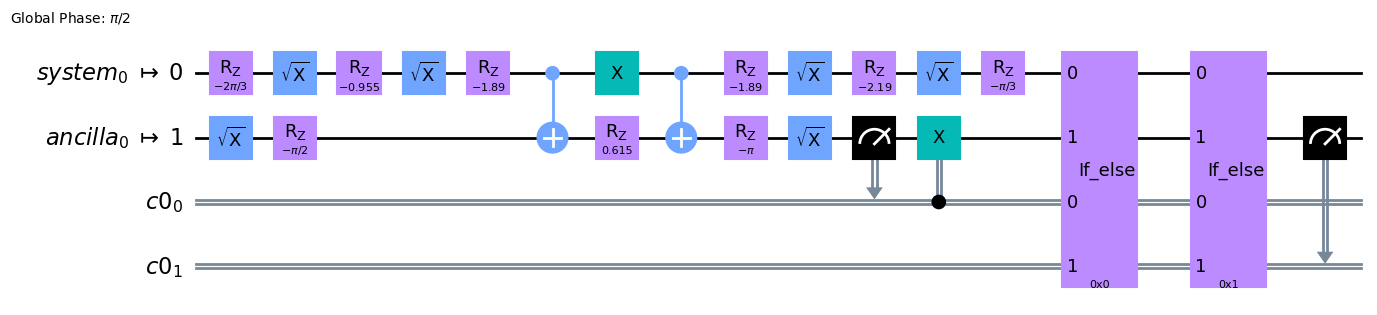

In [23]:
# we use optimization_level=1 because at the time of writing higher
# transpiler optimizations were not yet available for dynamic circuits
transpiled_qc = transpile(btp.qc, backend, optimization_level=1)
transpiled_qc.draw('mpl', idle_wires=False)

In [24]:
noisy_counts = simulator_noisy.run(transpiled_qc).result().get_counts()

A measurement outcome $M_j$ occurs with probability $p_j = Tr[M_j\rho]$ where $\rho$ is the initial state of the system. We can therefore precalculate the expected probability distribution by computing the expectation value for each $M_j$. This functionality is implemented in the `theoretical_probs()` function and returns a dictionary of outcomes and their probabilities.

In [25]:
theo_probs = theoretical_probs(povm, state, binary_tree=True)

In [26]:
legend = ['Theory', 'Simulation with readout errors']
data = [theo_probs, noisy_counts]

The histogram below shows the effect of readout errors in the binary tree circuit.

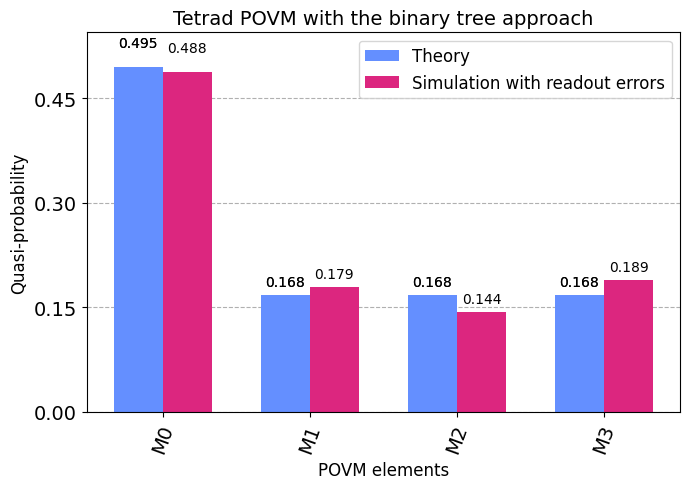

In [27]:
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

fig = plot_histogram(data, legend=legend, bar_labels=True)
ax = fig.axes[0]
title = f'Tetrad POVM with the binary tree approach'
ax.set_title(title, fontsize=14)
ax.set_ylabel('Quasi-probability', fontsize=12)
ax.set_xlabel('POVM elements', fontsize=12)
x = ['M0','M1','M2','M3']
ax.set_xticklabels(x)
ax.legend(fontsize=12)

fig.tight_layout()
plt.sca(ax)
plt.show()

### Running binary circuit on real hardware

You can obtain hardware results for the binary tree approach by following the steps in [this section](#mid-circuit) of the appendix. The figure below shows one of the previous hardware experiments.

![binary_tree_hw_results](https://raw.githubusercontent.com/petr-ivashkov/qamp-generalized-measurements-img/master/Images/binary_tree_hw_results.png)

## Appendix <a id='appendix'></a>

### Constructing measurement operators for the binary tree

Consider a set of measurement operators $M_j$, which constitute a POVM. To perform the first step of the binary search, we partition this set into two cumulated operators:

$$B_1 = \sum_{j=0}^{N/2-1}M_j = M_0 + M_1$$ 

$$B_2 = \sum_{j=N/2}^{N-1}M_j = M_2 + M_3$$

The two cumulated operators constitute a two-outcome POVM which must be measured through a non-destructive measurement by coupling the system to a single ancilla qubit. The measurement outcome can be seen as the first step in a measurement trajectory, which ends at the fine-grain level. We halve the number of possible POVM outcomes at each subsequent measurement, thus going down the binary tree.

![binary_tree](https://raw.githubusercontent.com/petr-ivashkov/qamp-generalized-measurements-img/master/Images/binary_tree.png)

Following the same logic, we partition the set $M_{0..N/2-1}$ into two and measure a binary POVM again. This time, however, we need to account for the evolved post-measurement state $^1$ of the system: 

$$\rho_j' = \frac{m_j\rho m_j^{\dagger}}{Tr[m_j\rho m_j^{\dagger}]}$$

where a possible $m_j$ can be obtained from $m_j^{\dagger}m_j = M_j$ as $m_j = \sqrt{M_j}$

For instance, we cannot perform the fine-grain measurement $M_{0..N/2-1}$ on the evolved state $\rho_j'$. To adjust the state for further measurement, we modify the sequential measurement in a way that the probability distribution for the modified measurement on the evolved state is the same as from performing the original measurement on the initial state: 

$$Tr[\rho M_j] = Tr[\rho' M_j']$$ 

The [original paper](https://arxiv.org/abs/0712.2665) proves that one can write the required Kraus operators as:

$$b_{0..N/4-1} = m_{{0..N/4-1}}\bar m_{{0..N/2-1}}^{-1} + g_{{0..N/2-1}}$$

where $\bar m_{{0..N/2-1}}^{-1}$ is the Moore-Penrose pseudo-inverse of $m_{{0..N/2-1}}$ and $g_{{0..N/2-1}}$ guarantees the completeness of $M_j'$. Similarly, we construct the Kraus operators for every binary-outcome POVM. 

$$b_{ij} = m_{{ij}}\bar m_{{i}}^{-1} + g_{{i}}$$

Please refer to the original paper by [Andersson and Oi](https://arxiv.org/abs/0712.2665) for detailed proof. 

$^1$ Note that this state is not uniquely defined because of the unitary freedom $m_j \rightarrow Um_j$.

### Mid-circuit measurements <a id='mid-circuit'></a>

Recently, IBM [announced](https://research.ibm.com/blog/quantum-dynamic-circuits) the support for dynamic circuits on IBM quantum devices. Dynamic circuits, as opposed to static circuits, allow to apply operations conditioned on classical outcomes, which are produced at runtime and therefore utilize mid-circuit measurements. This feature can significantly increase the variety of circuits by allowing for adaptive control and feed-forward operations.

Dynamic circuits require the backend to support QASM3. At the time of writing, only selected backends had this support, but more will be added in the future. The list of backends that support QASM3 and are available with your provider can be obtained by setting `dynamic=True` to communicate to the backend that we want to run a dynamic circuit.

Dependent on your provider, you can have access to different quantum backends. In the following, we will retrieve publicly available devices which support dynamic circuits.

In [28]:
# backends supporting dynamic circuits
backends = [backend for backend in IBMProvider().backends(dynamic_circuits=True)]
print("Publicly available devices which support dynamic circuits are:")
for backend in backends: print(backend.name)

Publicly available devices which support dynamic circuits are:
ibmq_jakarta
ibmq_manila
ibm_lagos
ibm_nairobi
ibm_perth
ibm_oslo


To submit dynamic circuits to a quantum backend, we set `dynamic=True` when calling the `run()` function. This method invokes the `qasm3-runner`, which is a Qiskit Runtime program.

In [29]:
# The following code submits binary measurement circuit to ibm_nairobi
# Uncomment it if you want to obtain hardware resultsa
'''
backend = provider.get_backend('ibm_nairobi')

job = backend.run(transpiled_qc, dynamic=True)
print(f"Job ID: {job.job_id}")
print(f"Job status: {job.status()}")
'''

'\nbackend = provider.get_backend(\'ibm_nairobi\')\n\njob = backend.run(transpiled_qc, dynamic=True)\nprint(f"Job ID: {job.job_id}")\nprint(f"Job status: {job.status()}")\n'

Alternatively, one can directly submit circuits to `qasm3-runner`, which converts them to OpenQASM3, compiles, and executes them. This program can also take and execute one or more OpenQASM3 strings.

Independent of the selected method, one can retrieve the results after the job has been processed as follows:

In [30]:
# notice that the following call is blocking and will
# block your environment if the job is not ready
'''
counts = job.result().get_counts()
'''

'\ncounts = job.result().get_counts()\n'

### Selecting an optimal layout using mapomatic

Given the access to different quantum backends, we want to choose the best hardware to run our circuit such that the effect of noise is minimized. In general, qubits with the longest coherence times should be preferred for the mapping. However, qubit connectivity is also essential to minimize the number of SWAP gates. However, a mapping that is optimal in terms of the number of SWAP gates may not have the best qubits. Therefore, selecting an optimal layout for your circuit is a nontrivial task. We use an open-source Qiskit extension, `mapomatic`, to find a good qubit layout. 

`mapomatic` is *"... a post-compilation routine that finds the best low noise sub-graph on which to run a circuit given one or more quantum systems as target devices."* It uses a heuristic to grade different qubit layouts based on calibration data of qubits. For more on this, please refer to the [source code](https://github.com/Qiskit-Partners/mapomatic) or the [original paper](https://arxiv.org/abs/2209.15512).

The function `best_overall_layout()` evaluates layouts based on the total error rate from gate and readout errors to find a good candidate out of multiple systems and layouts:

In [31]:
import mapomatic
# Note: evaluating all available backends might block the environment for a long period
'''
mapomatic.best_overall_layout(transpiled_qc, provider.backends(), successors=True)
'''

'\nmapomatic.best_overall_layout(transpiled_qc, provider.backends(), successors=True)\n'

## Implementation <a id='implementation'></a>

The following sections contain the Python implementation of the binary tree and Naimark's algorithms. Once you execute these sections, return to the [beginning](#beginning) of the notebook.

### Implementing binary search tree circuit

In [32]:
import numpy as np
import scipy

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.extensions import UnitaryGate

# Helper functions section:
def get_measurement_op(povm, start, end):
    """
    Returns a cumulative measurement operator by grouping together
    POVM elements from povm[start] to povm[end-1]
    """
    return np.sum(povm[start:end],axis=0).round(5)

def get_diagonalization(povm, start, end):
    """
    Returns: 
        Kraus operator <M>, diagonal <D> and the modal matrix <V> for a given 
        measurement operator by diagonalizing the measurement operator in the form:

        M = V@D@Vh such that M@M = E
    """
    E = get_measurement_op(povm, start, end)
    d2,V = np.linalg.eig(E)
    D = np.real(np.sqrt(np.diag(d2)))
    M = V@D@np.linalg.inv(V)
    return M,D,V

def get_next_level_binary_kraus_ops(povm, start, end):
    """
    Computes two next level binary Kraus operators 
    Args:
        povm: numpy array of POVM elements
        start/end: indices which define the cumulative POVM element
    Returns: 
        Two binary Kraus operators b0 and b1 which take from a higher to lower branch

    * <M> is the Kraus operator corresponding to the current level in binary tree
    * <M0> (<M1>) is the Kraus operators corresponding to the left (right) branch
    * <Q> asserts the completeness condition: b0@b0.T.conj() +  b1@b1.T.conj() = I
    * <M_psinv> is the Moore-Penrose pseudo-inverse of <M>
    """
    mid = int(start + (end-start)/2)
    # computing <M>
    M,D,V = get_diagonalization(povm, start, end)
    # computing the null space of <M>
    P = np.sign(D.round(5))
    Pc = np.eye(len(M))-P
    Q = V@Pc@V.T.conj()
    # computing <M_psinv>
    #D_inv = np.zeros_like(D)
    #for i in range(len(M)):
    #    if D[i,i].round(5) == 0: continue
    #    else: D_inv[i,i] = np.real(1/D[i,i])
    D_inv = np.linalg.pinv(D)
    M_psinv = V@D_inv@V.T.conj()
    # computing <M0> and <M1>
    M0,_,_ = get_diagonalization(povm, start, mid)
    M1,_,_ = get_diagonalization(povm, mid, end)
    # computing <b0> and <b1>
    b0 = M0@M_psinv + Q/np.sqrt(2)
    b1 = M1@M_psinv + Q/np.sqrt(2)
    return b0, b1

def closest_unitary(A):
    """ Calculates the unitary matrix U that is closest with respect to the
        operator norm distance to the general matrix A.
    """
    V, _, Wh = scipy.linalg.svd(A)
    U = np.matrix(V.dot(Wh))
    return U

def closest_unitary_schur(A):
    T, Z = scipy.linalg.schur(A, output='complex')
    return Z @ np.diag(np.diag(T)/abs(np.diag(T))) @ Z.T.conj()

def extend_to_unitary(b0, b1):
    """ Creates a coupling unitary between the system and ancilla.

        The condition for unitary is: <0|U|0> = b0 and <1|U|0> = b1,
        whereby the ancilla is projected onto states |0> and |1>.

        A two-column matrix A, with its upper left block given by b0, 
        and bottom left block by b1, is extended to unitary U by appending  
        a basis of the null space of A.
    """ 
    A = np.concatenate((b0,b1))
    u, _, _ = scipy.linalg.svd(A)
    y = u[:, len(A[0]):]
    U = np.hstack((A, y))
    # verify U is close to unitary
    assert np.allclose(U.T.conj()@U, np.eye(len(A)),atol=1e-03), "Failed to construct U"
    return closest_unitary(U)

def theoretical_probs(povm, state, binary_tree=False):
    """ Precalculates the expected probabilities for a pure state
        for the given POVM.
    """   
    rho = state.T.conj()@state # density matrix of the state
    probs = [np.trace(povm[i]@rho).round(2).real for i in range(len(povm))] 
    
    l = len(probs)
    n = int(np.ceil(np.log2(l)))
    prob_counts = {}
    for i in range(l):
        if binary_tree: key = np.binary_repr(i, n)[::-1]
        else: key = np.binary_repr(i, n)
        value = probs[i]
        prob_counts[key] = value
    
    return prob_counts

# Class definitions
class POVM:
    """Base class that holds an arbitrary POVM <povm> as a list of <N> POVM elements.
    """
    def __init__(self, povm):
        """
        Constructor asserts that the given POVM is valid.
        """
        self.povm = povm
        self.N = len(povm)
        self.depth = int(np.ceil(np.log2(self.N))) # required depth of the binary tree
        self.povm_dim = len(povm[0]) # dimension of the POVM operators
        self.n_qubits = int(np.log2(self.povm_dim)) # number of system qubits
        assert self.is_valid()
    def is_valid(self):
        """Verifies the hermiticity, positivity of the POVM and that
        the POVM resolves the identity.
        Returns:
            True: if all conditions are satisfied
        Raises:
            Assertion Error: if one of conditions is not satisfied
        """
        for E in self.povm:
            assert np.allclose(E.conj().T, E), "Some POVM elements are not hermitian"
            assert np.all(np.linalg.eigvals(E).round(3) >= 0), "Some POVM elements are not positive semi-definite"
        assert np.allclose(sum(self.povm), np.eye(self.povm_dim)), "POVM does not resolve the identity"
        return True

class BinaryTreePOVM(POVM):
    """Class which implements the binary tree approach as described in https://arxiv.org/abs/0712.2665 
    to contruct a POVM measurement tree. 
    """
    def __init__(self, povm, dual=False):
        """Creates a binary stree structure with BinaryMeasurementNode objects
        stored in <nodes> dictionary. The keys in the dictionary are the bitstrings 
        corresponding to the states of the classical register at the point when the
        corresponding node has been "reached".

        Args:
            povm: list of POVM elements
        """
        super().__init__(povm)
        # pad with zero operators if necessary
        while np.log2(self.N)-self.depth != 0:
            self.povm.append(np.zeros_like(self.povm[0]))
            self.N += 1
             
        self.nodes = {}
        self.dual = dual

        self.create_binary_tree(key="0", start=0, end=self.N)
        self.qc = self.construct_measurement_circuit()
    def create_binary_tree(self, key, start, end):
        """Recursive method to build the measurement tree.
        Terminates when the fine-grain level corresponding to the single POVM
        elements is reached.

        <start> and <end> are the first and (last-1) indices of POVM elements
        which were grouped together to obtain a cumulative coarse-grain operator. 
        The range [start, end) corresponds to the possible outcomes which "sit" in 
        the branches below.
        """
        if start >= (end-1):
            return
        new_node = BinaryMeasurementNode(self.povm, key=key, start=start, end=end)
        self.nodes[key] = new_node
        mid = int(start + (end-start)/2)
        self.create_binary_tree(new_node.left, start=start, end=mid)
        self.create_binary_tree(new_node.right, start=mid, end=end)        
    def construct_measurement_circuit(self):
        """Contructs a quantum circuit <qc> for a given POVM by sequentially appending
        coupling unitaries <U> and measurements conditioned on the state of the
        classical register <cr>. The method uses BFS traversal of the precomputed 
        binary measurement tree, i.e. the measurement nodes are visited in level-order.
        
        * Traversal terminates when the fine-grain level was reached.
        * Ancilla qubit is reset before each level.
        * The root node has the key "0".

        * The <if_test> instruction is applied to the entire classical register <cr>,
          whereby the value is the key of the corresponding node - padded with zeros 
          from right to the length of the <cr> register - and interpreted as an integer.
          
          Example:
            At the first level the two nodes have keys:
                left = "00" and right = "01"
            If the <cr> is 3 bits long, then the left/right unitary is applied if 
            the state of <cr> is int("000",2) = 0 / int("010",2) = 2
        """
        system = QuantumRegister(self.n_qubits, name='system')
        anc = QuantumRegister(1,name='ancilla')
        cr = ClassicalRegister(self.depth)
        qc = QuantumCircuit(system, anc, cr, name="measurement-circuit")

        root = self.nodes["0"]
        U_gate = UnitaryGate(root.U, label=root.key)
        qc.append(U_gate, system[:] + anc[:])
        if self.dual: # works for depth = 2
            qc.x(anc)
        qc.measure(anc, cr[0])
        if self.depth == 1: return qc
        qc.x(anc).c_if(cr[0],1)
    
        current_level = [self.nodes["00"],self.nodes["10"]]

        for i in range(1,self.depth):
            next_level = []
            for node in current_level:
                U_gate = UnitaryGate(node.U, label=node.key)
                cr_state = int(node.key[:-1],2)
                with qc.if_test((cr, cr_state)):
                    qc.append(U_gate, system[:]+anc[:])
                if node.left in self.nodes: next_level.append(self.nodes[node.left])
                if node.right in self.nodes: next_level.append(self.nodes[node.right])
                current_level = next_level
            # dual condition must be checked here for larger systems
            qc.measure(anc, cr[i])
            if i == self.depth-1: continue
            qc.x(anc).c_if(cr[i],1) # instead of resetting apply conditional X gate
            
        return qc

class BinaryMeasurementNode(POVM):
    """A BinaryMeasurementNode object is a node in the BinaryTreePOVM.
    It contains:
        1. Its <key> in the <nodes> dictionary.
        2. <start> and <end>: the first and (last-1) indices of the accumulated 
        POVM elements, corresponding this node.
        3. Coupling unitary <U>.
        4. Keys <left> and <right> of the two children nodes.
        5. Attributes of the POVM class: <M>, <N>, <M_dim>.
        6. Its level <level> in the binary tree, where level of the root node is 0.
    """
    def __init__(self, povm, key, start, end):
        super().__init__(povm)
        self.key = key
        self.level = len(self.key)-1
        self.start = start
        self.end = end
        self.left = "0" + self.key
        self.right = "1" + self.key
        b0, b1 = get_next_level_binary_kraus_ops(self.povm, self.start, self.end)
        self.U = extend_to_unitary(b0, b1)
    def __str__(self):
        line1 = 'Node with the key {} at level {}\n'.format(self.key, self.level)
        line2 = 'Cumulative operator = [{},{})'.format(self.start, self.end)
        line3 = 'left = {}, right = {}\n'.format(self.left, self.right)
        line4 = 'U = \n{}\n'.format(self.U)
        return line1+line2+line3+line4

### Implementing Naimark's extension circuit

In [33]:
from numpy.linalg import svd
from qiskit.visualization import plot_histogram

def check_for_rank_one(povm):
    """
    function to check if a povm is a rank-1 povm
    """
    rank_one = True
    for p in povm:
        if np.linalg.matrix_rank(p)!=1:
            rank_one = False
            return rank_one
        else:
            continue
    return rank_one
            
# %%
def compute_rank_one_unitary(povm, atol=1e-13, rtol=0):
    """
    This function computes the unitary that rotates the system to the Hilbert space of the ancilla
    Input:  POVM ---> a list of the elements of POVM
    Output: Unitary matrix
    """
           
    # check if povm is a rank-1 povm:
    assert check_for_rank_one(povm), "This is not a rank-1 povm"
    new_povm = []
    for p in povm:
        if np.log2(len(povm))%2==0: #still under investigation
            w, v = np.linalg.eig(p)
        else: 
            w, v = np.linalg.eigh(p) #note the that the eigenvenvector is computer for hermitian eigh
        for eigenvalue, engenvector in zip(w,v):
            if np.isclose(np.abs(eigenvalue), 0):
                continue
            else:
                new_p = np.sqrt(eigenvalue)*engenvector
                new_povm.append(new_p)
    v = np.vstack(new_povm) # arrange the povm elements to form a matrix of dimension: Row X Col*len(povm)
    v = np.atleast_2d(v.T) # convert to 2d matrix
    
    u, s, vh = svd(v)    # apply svd
    tol = max(atol, rtol * s[0])
    nnz = (s >= tol).sum()
    ns = vh[nnz:]         # missing rows of v
    
    # add the missing rows of v to v
    V = np.vstack((v, ns)) 
    
    
    # make the unitary a square matrix of dimension N=2^n where n = int(np.ceil(np.log(V.shape[0])))
    n = int(np.ceil(np.log2(V.shape[0])))
    N = 2**n      # dimension of system and ancilla Hilber space
    r,c = V.shape  
    
    U = np.eye(N, dtype=complex) # initialize Unitary matrix to the identity. Ensure it is complex
    U[:r,:c] = V[:r,:c] # assign all the elements of V to the corresponding elements of U
    
    U = U.conj().T  # Transpose the unitary so that the rows are the povm
    
    # check for unitarity of U
    assert np.allclose(U.T.conj()@U, np.eye(N),atol=1e-13), "Failed to construct U"
    
    return U
    
# %%
# Using the original unitary generator

def compute_full_rank_unitary(povm, atol=1e-13, rtol=0):
    """
    This function computes the unitary that rotates the system to the Hilbert space of the ancilla
    Input:  POVM ---> a list of the elements of POVM
    Output: Unitary matrix
    """
    
         
    # Here square root of the POVM elements were used as a replacement for the vector that form the povm
    povm = [sqrtm(M)for M in povm]
    
    v = np.hstack(povm) # arrange the povm elements to form a matrix of dimension: Row X Col*len(povm)
    v = np.atleast_2d(v) # convert to 2d matrix
    u, s, vh = svd(v)    # apply svd
    tol = max(atol, rtol * s[0])
    nnz = (s >= tol).sum()
    ns = vh[nnz:]         # missing rows of v
    
    # add the missing rows of v to v
    V = np.vstack((v, ns)) 
    
    
    # make the unitary a square matrix of dimension N=2^n where n = int(np.ceil(np.log(V.shape[0])))
    n = int(np.ceil(np.log2(V.shape[0])))
    N = 2**n      # dimension of system and ancilla Hilber space
    r,c = V.shape  
    
    U = np.eye(N, dtype=complex) # initialize Unitary matrix to the identity. Ensure it is complex
    U[:r,:c] = V[:r,:c] # assign all the elements of V to the corresponding elements of U
    
    U = U.conj().T  # Transpose the unitary so that the rows are the povm
    
    # check for unitarity of U
    assert np.allclose(U.T.conj()@U, np.eye(N),atol=1e-07), "Failed to construct U"
    
    return U

# %%
def rank_one_circuit(povm, state, U):
    
    # Define the quantum and classical registers
    dim_system = state.shape[1] # dimension of state
    num_system_qubit = int(np.ceil(np.log2(dim_system))) # total number of qubits for system

    system_reg = QuantumRegister(num_system_qubit, name='system') # system register

    N = U.shape[0] # Dimension of the unitary to be applied to system and ancilla

    num_ancilla_qubit = int(np.ceil(np.log2(N))) - num_system_qubit # total number of qubits for system

    ancilla_reg = QuantumRegister(num_ancilla_qubit, name='ancilla') # ancilla register

    U_gate = UnitaryGate(U, label='U') # unitary gate to be applied between system and ancilla
    
    
    # create the quantum circuit for the system and ancilla
    qc = QuantumCircuit(system_reg, ancilla_reg, name='circuit')
    qc.initialize(state[0],system_reg)

    # reset ancilla to zero
    qc.reset(ancilla_reg)

    # append the unitary gate
    qc.append(U_gate, range(system_reg.size + ancilla_reg.size))

    # measure only the ancilliary qubits
    qc.measure_all()
    
    return qc

# %%
def full_rank_circuit(povm, state, U):
    
    # Define the quantum and classical registers
    dim_system = state.shape[1] # dimension of state
    num_system_qubit = int(np.ceil(np.log2(dim_system))) # total number of qubits for system

    system_reg = QuantumRegister(num_system_qubit, name='system') # system register

    N = U.shape[0] # Dimension of the unitary to be applied to system and ancilla

    num_ancilla_qubit = int(np.ceil(np.log2(N))) - num_system_qubit # total number of qubits for system

    ancilla_reg = QuantumRegister(num_ancilla_qubit, name='ancilla') # ancilla register

    classical_reg = ClassicalRegister(num_ancilla_qubit, name='measure') # classical register

    U_gate = UnitaryGate(U, label='U') # unitary gate to be applied between system and ancilla
    
    
    # create the quantum circuit for the system and ancilla
    qc = QuantumCircuit(system_reg, ancilla_reg, classical_reg, name='circuit')
    qc.initialize(state[0],system_reg)

    # reset ancilla to zero
    qc.reset(ancilla_reg)

    # append the unitary gate
    qc.append(U_gate, range(system_reg.size + ancilla_reg.size))

    # measure only the ancilliary qubits
    qc.measure(ancilla_reg, classical_reg)
    
    return qc

# %%
def construct_quantum_circuit(povm, state):
    
    # compute unitary matrix
    if check_for_rank_one(povm):
        U = compute_rank_one_unitary(povm)
        qc = rank_one_circuit(povm, state, U)
    else:
        U = compute_full_rank_unitary(povm)
        qc = full_rank_circuit(povm, state, U)
    
    return qc

# %%
def draw_circuit(qc, idle_wires=True):
    """
    This functions draws the naimark extension quantum circuit
    """
    
    return qc.draw(output='mpl', idle_wires=idle_wires)

def naimark_plot(povm, state, counts, names, save=False, file_name="povm_output.pdf"):  
    theory_count = theoretical_probs(povm, state)
    count_list = [theory_count]
    #legend_list = ["Theoretical result"]
    legend_list = ['Theory (t)']
        
    for count, name in zip(counts, names):
        count_list.append(count)
        legend_list.append(name)
    
    fig = plot_histogram(count_list, legend=legend_list, bar_labels=True)
    ax = fig.axes[0]
    title = f"Tetrad POVM with Naimark's extension approach"
    ax.set_title(title, fontsize=12)
    ax.set_ylabel('Probabilities', fontsize=12)
    ax.set_xlabel('POVM elements', fontsize=12)
    
    x_lables = []
    for i in range(len(povm)):
        x_lables.append("M"+str(i))
    ax.set_xticks(range(len(povm)))
    ax.set_xticklabels(x_lables)
    
    ax.legend(fontsize=12)
    fig.tight_layout()
    
    if save:
        fig.savefig(file_name)
        
        
    return fig

## Qiskit version and copyright <a id='version'></a>

In [34]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright